# Reuters 딥러닝 모델

## 데이터 로드 및 전처리

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [2]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=77)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

6736
2246
2246
46


In [5]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
    one_hot_data = np.zeros((len(data), dim))
    for idx, seq in enumerate(data):
        one_hot_data[idx,seq] = 1.
    return one_hot_data

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
y_train = to_categorical(train_labels)
y_val = to_categorical(val_labels)
y_test = to_categorical(test_labels)

## 모델 구성 및 컴파일

In [7]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.

model2 = models.Sequential()
model2.add(layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(46, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1280128   
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 46)               

In [8]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
checkpoint_cb = callbacks.ModelCheckpoint("model2.h5", save_best_only=True)

callbacks_es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model2.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

history2 = model2.fit(x_train, 
                    y_train,
                    epochs=60,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint_cb, callbacks_es])      

Epoch 1/60
53/53 [==============================] - 2s 14ms/step - loss: 2.2423 - accuracy: 0.5428 - val_loss: 2.7189 - val_accuracy: 0.7195
Epoch 2/60
53/53 [==============================] - 0s 7ms/step - loss: 1.0312 - accuracy: 0.7957 - val_loss: 2.0887 - val_accuracy: 0.7150
Epoch 3/60
53/53 [==============================] - 0s 7ms/step - loss: 0.6516 - accuracy: 0.8723 - val_loss: 1.5986 - val_accuracy: 0.7551
Epoch 4/60
53/53 [==============================] - 0s 7ms/step - loss: 0.4536 - accuracy: 0.9102 - val_loss: 1.2962 - val_accuracy: 0.7636
Epoch 5/60
53/53 [==============================] - 0s 7ms/step - loss: 0.3398 - accuracy: 0.9341 - val_loss: 1.0786 - val_accuracy: 0.7952
Epoch 6/60
53/53 [==============================] - 0s 7ms/step - loss: 0.2763 - accuracy: 0.9455 - val_loss: 0.9767 - val_accuracy: 0.8019
Epoch 7/60
53/53 [==============================] - 0s 7ms/step - loss: 0.2500 - accuracy: 0.9492 - val_loss: 0.9383 - val_accuracy: 0.8166
Epoch 8/60
53/53 [=

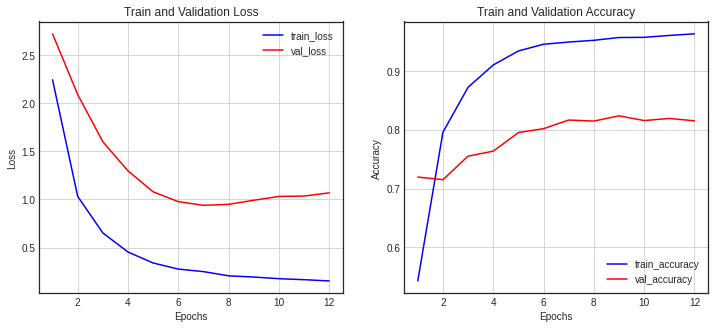

In [9]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history2.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

## 모델 평가 및 예측

In [10]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
test_loss, test_accuracy  = model2.evaluate(x_test, y_test)
print("테스트 데이터 loss : ", test_loss)
print("테스트 데이터 accuracy : ", test_accuracy )

71/71 [==============================] - 0s 3ms/step - loss: 1.0188 - accuracy: 0.7912
테스트 데이터 loss :  1.0188058614730835
테스트 데이터 accuracy :  0.7911843061447144
